In [1]:
import cv2
import numpy as np
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
%matplotlib inline

In [2]:
images=os.listdir('./camera_cal/')

#Initializing object and image points
objpoints = []  # 3D points
imgpoints = []  # 2D points
nx,ny = 9,6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

#Appending the corners to image points 
for fname in images:
    img = mpimage.imread('./camera_cal/'+fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#getting the distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [3]:
def undistort_image(image):
    undist_image=cv2.undistort(image, mtx, dist, None, mtx)
    return undist_image

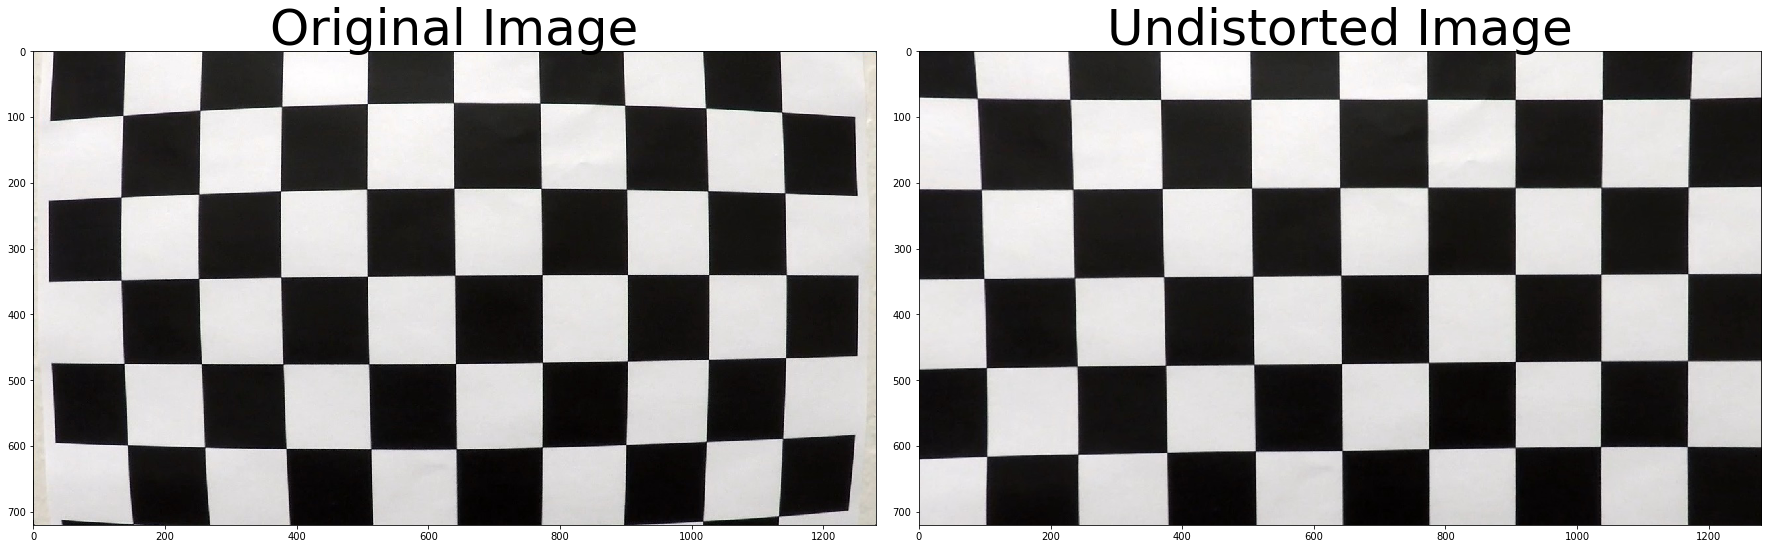

In [4]:
#Showing a example calibiration image and undistorted image
test_image=mpimage.imread('camera_cal/calibration1.jpg')
img_size=test_image.shape
undist_image=undistort_image(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 24))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

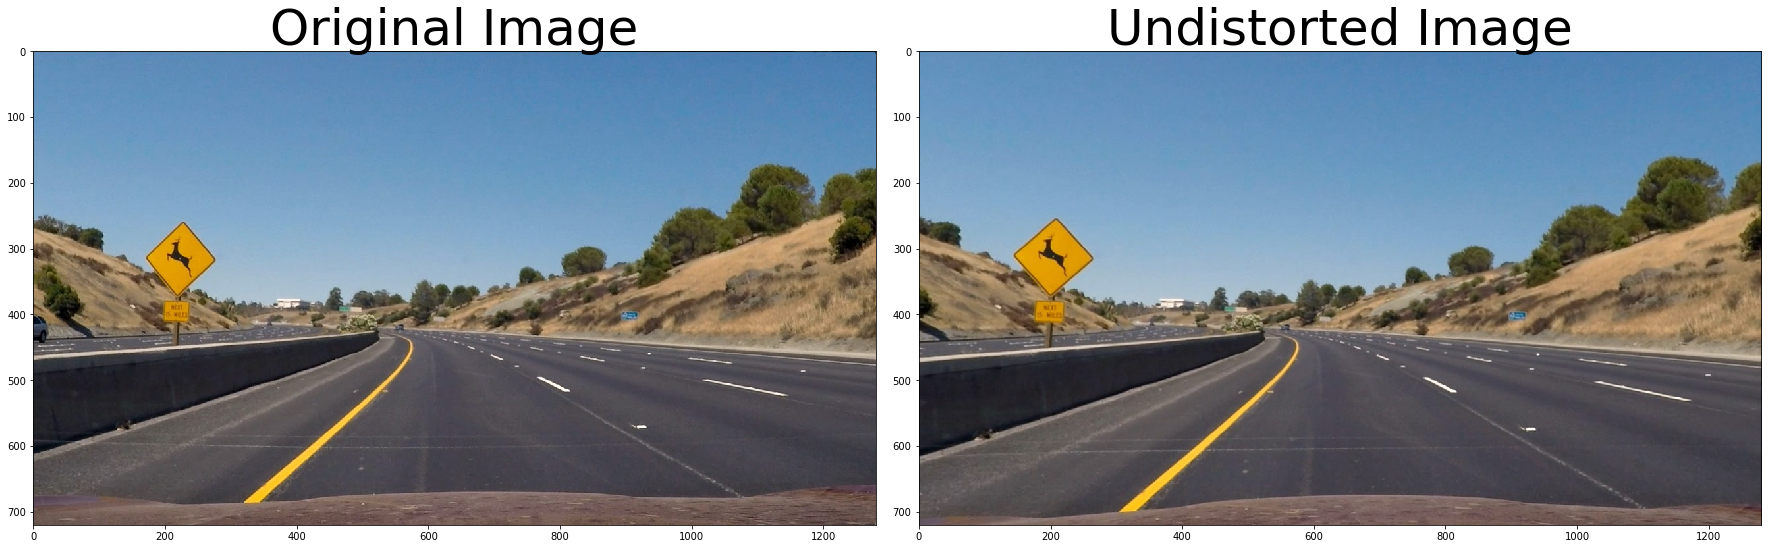

In [5]:
#Showing a example original image and undistorted image
test_image=mpimage.imread('test_images/test2.jpg')
img_size=test_image.shape
undist_image=undistort_image(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 24))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def color_gradient_threshold(img):
    '''
    #Convert the image into hls colour scale
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 150
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    s_thresh_min = 175
    s_thresh_max = 250
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    '''
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 1
    
    
    return combined_binary

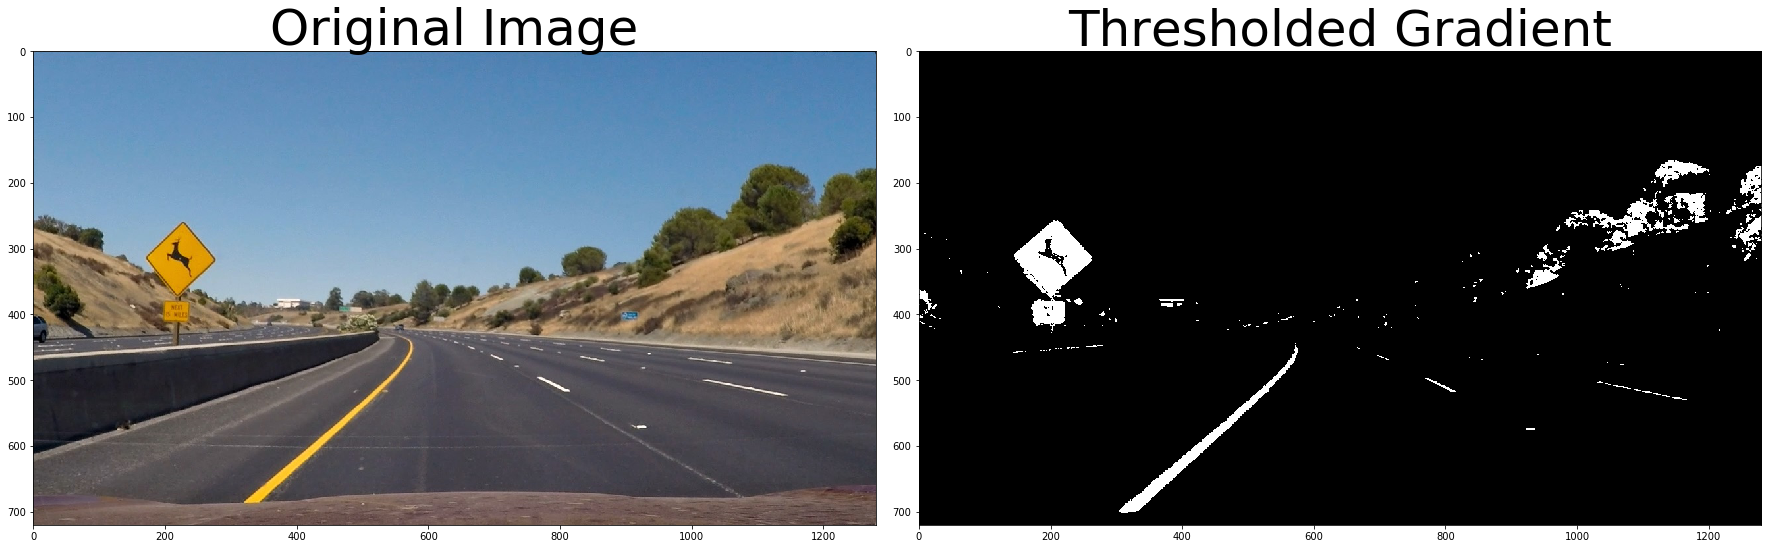

In [7]:
binary_image = color_gradient_threshold(undist_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    MinV=cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped,MinV

In [9]:
img_size=test_image.shape
src = np.float32([[(img_size[1] / 2) - 55, img_size[0] / 2 + 100], [((img_size[1] / 6) - 10), img_size[0]], [(img_size[1] * 5 / 6) + 60, img_size[0]],[(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
dst = np.float32( [[(img_size[1] / 4), 0], [(img_size[1] / 4), img_size[0]], [(img_size[1] * 3 / 4), img_size[0]], [(img_size[1] * 3 / 4), 0]])
warped_image,MinV=warper(binary_image,src,dst)

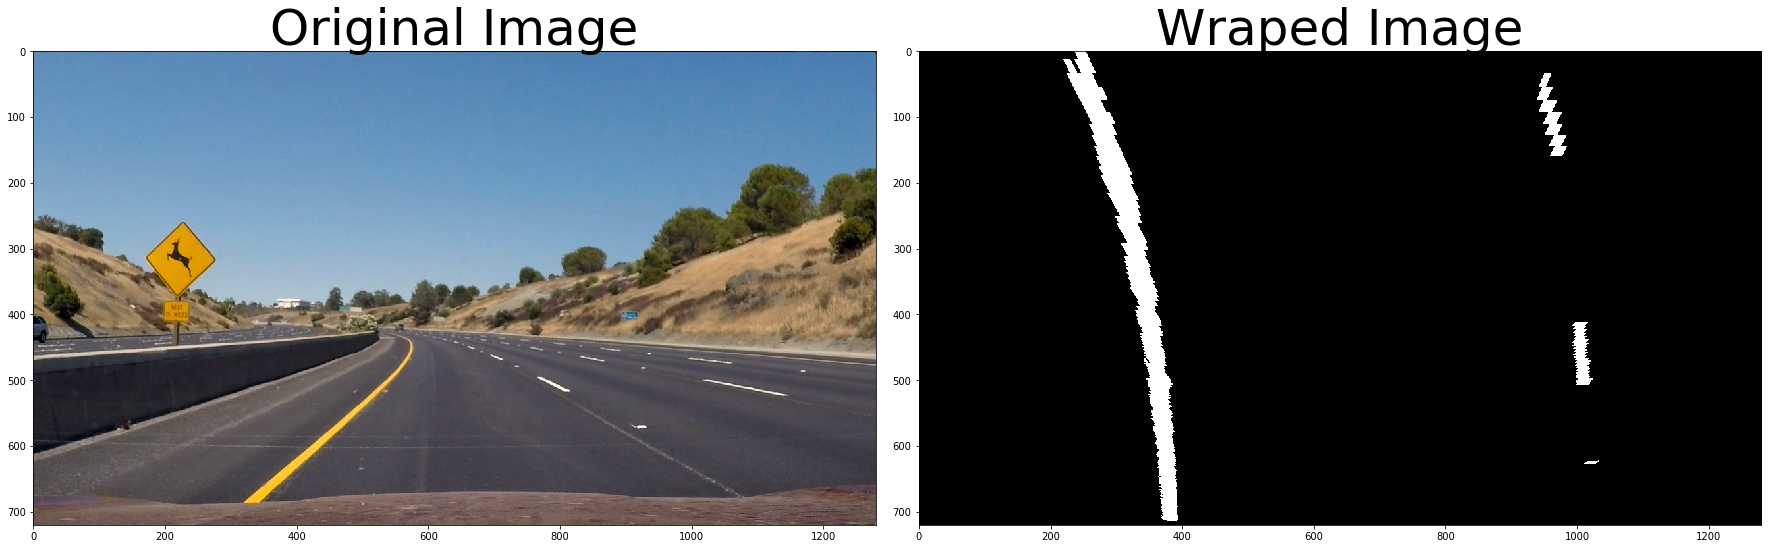

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Wraped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

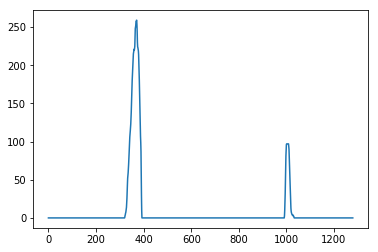

In [11]:
import numpy as np
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [12]:
def lane_line(warped_image):
    
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    #Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
    
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

In [13]:
def draw_line(image,warped_image,left_fit,right_fit,MinV):    
    

    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, MinV, (image.shape[1], image.shape[0])) 
    
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

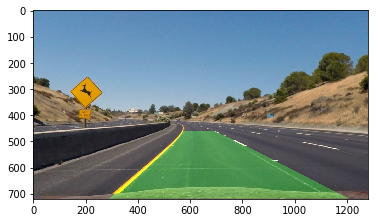

In [14]:
left_fit,right_fit=lane_line(warped_image)
result=draw_line(undist_image,warped_image,left_fit,right_fit,MinV)
plt.imshow(result)

In [15]:
def draw_curvature(image,left_fit,right_fit):
    
    #The Radius of curvatire and Distance calculation process is taken from github https://github.com/sumitbinnani/CarND-Advanced-Lane-Lines/
    
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 700
    midx = 650
    
    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    
    
    cv2.putText(image,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(image,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return image

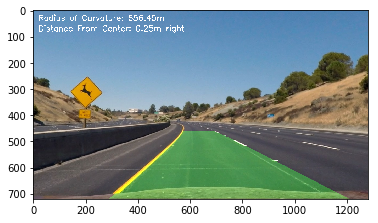

In [16]:
final=draw_curvature(result,left_fit,right_fit)
plt.imshow(final)

In [17]:
def image_pipeline(image):
    img_size=image.shape
    src = np.float32([[(img_size[1] / 2) - 55, img_size[0] / 2 + 100], [((img_size[1] / 6) - 10), img_size[0]], [(img_size[1] * 5 / 6) + 60, img_size[0]],[(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32( [[(img_size[1] / 4), 0], [(img_size[1] / 4), img_size[0]], [(img_size[1] * 3 / 4), img_size[0]], [(img_size[1] * 3 / 4), 0]])
    undist_image=undistort_image(image)
    binary_image=color_gradient_threshold(undist_image)
    warped_image,MinV=warper(binary_image,src,dst)
    left_fit,right_fit=lane_line(warped_image)
    result=draw_line(undist_image,warped_image,left_fit,right_fit,MinV)
    final=draw_curvature(result,left_fit,right_fit)
    return final
    

In [18]:
images=os.listdir("test_images/")
for i in images:
    image = mpimage.imread('test_images/'+str(i))
    result = image_pipeline(image)
    mpimage.imsave("output_images/"+str(i), result)

In [19]:
#Exeuting the video and saving it to the output folder
yellow_output = 'project_video_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(image_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:59<00:00,  8.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min
